Task - Linear regression Aim Perform a linear regression analysis (of your slice) of the Instacart dataset, predicting the number of days between orders.

Detail The problem to solve takes the form of Linear Regression with categorical independent variables.

Consider the sequence of orders placed by a customer. The hypothesis is that the typical product mix for that customer can be used to predict when the next order will be placed.

For training data, take an 80% subset of "relevant" orders, across all "relevant" users. From the first to the second last order, determine the product mix for that user, as well as the number of days until the next order for that user.

The training data is the remaining 20% subset of "relevant" orders, across all "relevant" users.

For example, if there were just 1 user and that user placed 11 orders, the training set could include the product mixes for each of the following 8 orders: 1, 2, 4, 5, 6, 7, 9, 10, together with the "days between orders" for each of the 8 order pairs (1,2), (2,3), (4,5), (5,6), (6,7), (7,8), (9,10), (10,11). In this case, the test data would include the product mix for order 3 and 8, together with the "days between orders" for each of the 2 order pairs (3,4) and (8,9).

Please note that the proposed 80:20 split is across user x order combinations.

Also, in practice, relevant implies an unbiased subset chosen to make the problem tractable with the computing resources available to each student.

For Independent variables, the product (mix) for order i-1 can be used, and the Dependent variable is the number of days between order i-1 and order i in that sequence for a given user.

Therefore the number of observations in the observation matrix is the number of users times the number of orders for each user.

Since there are 49688 distinct products, the dimensionality of the problem is very high, so students need to take account of this using:

roll up to aisle (134 unique) or department (21 unique) and build model accordingly use PCA to reduce the dimensions (of products, aisles and/or departments), and solve using the reduced-dimension model use regularisation and fit a constrained model. Disclaimers/Comments It is possible to obtain either per-user predictions (by solving a separate regression problem for each user) or a user-agnostic prediction (by merging the data for many users). It would be interesting to try both and compare, explaining what you find.

Much of this task relates to dimensionality reduction. In traditional BI, this would be done using roll-ups (e.g., from product to aisle), but linear regression offers other options. The BI approach is easier to interpret, because of the "meaningful" labels, but does it work as well? Give reasons for your answer!

Validating the results requires analysis of the outputs (and not just the predictions) of the linear regression model, e.g., R-squared and any other metrics you believe are helpful here.

Grading Outline 3 x 25% for each of the 3 regression model x dimensionality reduction options above, where the 25% consists of 5% Visualisation 10% formulation and solving 10% Validation/Comments/analysis. 25% for comparing per-user and multi-user models, and different methods for dimensionality reduction.

# imports

In [1]:
%matplotlib inline 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("paper")

from itertools import combinations, groupby
from collections import Counter
from mlxtend.preprocessing import TransactionEncoder
from sklearn import linear_model
from sklearn import preprocessing, cross_validation, svm

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn import model_selection
from sklearn.model_selection import train_test_split

from sklearn import svm

import sys

C:\Users\snolan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# create dataframes

In [2]:
orders_products_prior_full = pd.read_csv('instacart_2017_05_01/my_order_products__prior.csv')
orders_products_train_full = pd.read_csv('instacart_2017_05_01/my_order_products__train.csv')
orders_products = pd.concat([orders_products_prior_full, orders_products_train_full])

orders = pd.read_csv('instacart_2017_05_01/my_orders.csv')
products = pd.read_csv('instacart_2017_05_01/products.csv')
aisles = pd.read_csv('instacart_2017_05_01/aisles.csv')
departments = pd.read_csv('instacart_2017_05_01/departments.csv')

orders_a = pd.merge(orders, orders_products, on='order_id', how='inner').apply(lambda x: x)
columns = ['order_id', 'user_id', 'days_since_prior_order', 'product_id']
raw_data = pd.DataFrame(orders_a, columns=columns)
raw_data = pd.merge(raw_data, products, on='product_id', how='left').apply(lambda x: x)
raw_data = pd.merge(raw_data, aisles, on='aisle_id', how='left').apply(lambda x: x)
raw_data = pd.merge(raw_data, departments, on='department_id', how='left').apply(lambda x: x)

master_df = raw_data.copy()
print("Number of ordered products before/after merge : {} / {}".format(len(orders_products),len(master_df)))
master_df.head()


Number of ordered products before/after merge : 2374 / 2374


,order_id,user_id,days_since_prior_order,product_id,product_name,aisle_id,department_id,aisle,department
0,3308693,1886,NaN,42972,Natural Pure Sparkling Water,115,7,water seltzer sparkling water,beverages
1,3308693,1886,NaN,47977,Grapefruit Sparkling Water,115,7,water seltzer sparkling water,beverages
2,3308693,1886,NaN,30696,Eggo Homestyle Waffles,52,1,frozen breakfast,frozen
3,1019221,1886,6.0,9623,Sparkling Natural Spring Water,115,7,water seltzer sparkling water,beverages
4,1019221,1886,6.0,35914,Dha Omega 3 Reduced Fat 2% Milk,84,16,milk,dairy eggs


# calculate top selling products

In [3]:
threshold = 18
c = master_df["product_name"].value_counts().gt(threshold) #18 returns top 10 (11/876)
top_ten_products_df = master_df.loc[master_df["product_name"].isin(c[c].index)]
top_ten_products = top_ten_products_df["product_name"].unique()
print("{} products appear at least {} times".format(len(top_ten_products), threshold))

threshold = 13
c = master_df["product_name"].value_counts().gt(threshold) #13 returns top 20 (21/876)
top_twenty_products_df = master_df.loc[master_df["product_name"].isin(c[c].index)]
top_twenty_products = top_twenty_products_df["product_name"].unique()
top_ten_to_twenty_products = [item for item in top_twenty_products_df["product_name"].unique() if item not in top_ten_products]
print("{} products appear at least {} times".format(len(top_twenty_products), threshold))

threshold = 8
c = master_df["product_name"].value_counts().gt(threshold) #8 returns top 50 (53/876)
top_fifty_products_df = master_df.loc[master_df["product_name"].isin(c[c].index)]
top_fifty_products = top_fifty_products_df["product_name"].unique()
top_twenty_to_fifty_products = [item for item in top_fifty_products_df["product_name"].unique() if item not in top_twenty_products and item not in top_ten_products]
print("{} products appear at least {} times".format(len(top_fifty_products), threshold))

threshold = 4
c = master_df["product_name"].value_counts().gt(threshold) #4 returns top 100 (123/876)
top_hundred_products_df = master_df.loc[master_df["product_name"].isin(c[c].index)]
top_hundred_products = top_hundred_products_df["product_name"].unique()
top_fifty_to_hundred_products = [item for item in top_hundred_products_df["product_name"].unique() if item not in top_fifty_products and item not in top_twenty_products and item not in top_ten_products]
print("{} products appear at least {} times".format(len(top_hundred_products), threshold))

master_df["product_name"].value_counts().head()

11 products appear at least 18 times
21 products appear at least 13 times
53 products appear at least 8 times
123 products appear at least 4 times


Banana                          63
Bag of Organic Bananas          31
Natural Pure Sparkling Water    25
Organic Half & Half             24
Apple Honeycrisp Organic        23
Name: product_name, dtype: int64

# Get the 'aisle mix' and the 'days until next order' for each order

In [4]:
orders_enhanced = orders.copy()
orders_enhanced["days_until_next_order"] = orders["days_since_prior_order"].shift(-1).dropna()
orders_enhanced = orders_enhanced.drop(["eval_set","order_dow","order_hour_of_day","days_since_prior_order"], axis=1)
orders_enhanced.columns = ["index","order_id","user_id","order_number","days_until_next_order"]
orders_enhanced = orders_enhanced.set_index("index")
aisle_mix_df = pd.DataFrame(master_df.groupby("order_id")['aisle'].apply(list))
orders_enhanced =  pd.merge(orders_enhanced.reset_index(),aisle_mix_df.reset_index(),on="order_id").drop(["index"],axis=1)
orders_enhanced = orders_enhanced.dropna() # get rid of the ones we don't know yet
orders_enhanced.head()

,order_id,user_id,order_number,days_until_next_order,aisle
0,3308693,1886,1,6.0,"[water seltzer sparkling water, water seltzer ..."
1,1019221,1886,2,7.0,"[water seltzer sparkling water, milk, nuts see..."
2,3410026,1886,3,5.0,"[milk, water seltzer sparkling water, water se..."
3,2727369,1886,4,7.0,"[water seltzer sparkling water, water seltzer ..."
4,94907,1886,5,7.0,"[water seltzer sparkling water, water seltzer ..."


In [5]:
#for each aisle mix - determine which aisles are represented in the that mix
#if the basket contains a product from a given aisle, that aisle is given a value of 1
#if the basket does not contain a product from a given aisle, that aisle is given a value of 0
rows = []
unique_aisles = master_df["aisle"].unique()
orderids = orders_enhanced["order_id"]
orders_enhanced_copy = orders_enhanced.copy().set_index("order_id")
for orderid in orderids:   
    row = {}
    #flatten the aisle lists
    inner_list = [item for sublist in orders_enhanced_copy.loc[orderid,["aisle"]].tolist() for item in sublist] 
    row["order_id"] = orderid
    for aisle in unique_aisles:       
        row[aisle] = 1 if aisle in inner_list else 0        
    rows.append(row)
df_timeline_all_users = pd.DataFrame(rows, columns=rows[0].keys())
    
df_timeline_complete = pd.merge(orders_enhanced, df_timeline_all_users, on="order_id", left_index=True)

df_timeline_complete.head()

302
302


,order_id,user_id,order_number,days_until_next_order,aisle,water seltzer sparkling water,frozen breakfast,milk,nuts seeds dried fruit,asian foods,...,packaged poultry,trash bags liners,plates bowls cups flatware,canned fruit applesauce,more household,frozen vegan vegetarian,diapers wipes,air fresheners candles,refrigerated pudding desserts,soap
0,3308693,1886,1,6.0,"[water seltzer sparkling water, water seltzer ...",1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1019221,1886,2,7.0,"[water seltzer sparkling water, milk, nuts see...",1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3410026,1886,3,5.0,"[milk, water seltzer sparkling water, water se...",1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2727369,1886,4,7.0,"[water seltzer sparkling water, water seltzer ...",1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,94907,1886,5,7.0,"[water seltzer sparkling water, water seltzer ...",1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df_timeline = df_timeline_complete.drop(['order_id','user_id', 'order_number'], axis=1)
y = df_timeline['days_until_next_order']
X = df_timeline.drop(['aisle','days_until_next_order'], axis=1)

lm = linear_model.LinearRegression()
model = lm.fit(X,y)
predictions = lm.predict(X)
score = lm.score(X,y)

print("The R squared score is {}. This is the percentage of 'explained variance' of the predictions".format(score))

The R squared score is 0.5414891061148941. This is the percentage of 'explained variance' of the predictions


In [7]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size=0.2)
from sklearn import svm
clf=svm.LinearSVC()

clf.fit(X_train,Y_train)
print(clf)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


In [8]:
#predict days between the last and next order
print(clf.predict(X_test[0:1]))
#predicts days between the next ten orders
print(clf.predict(X_test[0:10]))
print(clf.score(X_test,Y_test))

[9.]
[ 9.  6.  0.  9.  7.  8.  3.  1. 10. 14.]
0.09836065573770492


In [9]:
#X = preprocessing.scale(X)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)
for k in ['linear','sigmoid','poly','rbf']:
    clf = svm.SVR(kernel=k)
    clf.fit(X_train, y_train)
    confidence = clf.score(X_test, y_test)
    print(k,confidence) 

linear -0.08922906372682693
sigmoid -0.01336629552654145
poly -0.03794546906835161
rbf -0.0006000963426930905


In [10]:
model = linear_model.LinearRegression()
def findNextBestPredictor(X,foundPredictors):
    nP = X.shape[1] # number of columns in X
    allPredictors = list(X) # See https://stackoverflow.com/a/19483025
    predictorsToSearch = set(allPredictors) - set(foundPredictors)
    maxScore = 0 # can usually do better than this!
    for predictor in predictorsToSearch: # loop over all remaining columns (predictors) in X
        trialPredictors = set(foundPredictors)
        trialPredictors.add(predictor) # Add this predictor to the existing predictors
        XcolSubset = X.loc[:,trialPredictors] # all rows and just the trial predictors
        model.fit(XcolSubset, y) # fit the model to y
        score = model.score(XcolSubset, y)
        if score > maxScore: # identify the largest score and its associated predictor
            maxScore = score
            bestPredictorFound = predictor

    return (maxScore, bestPredictorFound)

findNextBestPredictor(X, list())

(0.045992873248080435, 'milk')

In [11]:
nP = X.shape[1]
scores = [0]
foundPredictors = list()

for i in range(nP): # loop over all columns (predictors) in X
    (score, bestPredictorFound) = findNextBestPredictor(X, foundPredictors)
    foundPredictors.append(bestPredictorFound)
    scores.append(score)

print(foundPredictors)
print(scores)

['milk', 'doughs gelatins bake mixes', 'mint gum', 'paper goods', 'cream', 'vitamins supplements', 'frozen appetizers sides', 'yogurt', 'digestion', 'poultry counter', 'bulk dried fruits vegetables', 'bread', 'soap', 'honeys syrups nectars', 'more household', 'instant foods', 'butter', 'refrigerated', 'air fresheners candles', 'dry pasta', 'beauty', 'breakfast bars pastries', 'juice nectars', 'frozen meals', 'frozen produce', 'preserved dips spreads', 'eggs', 'protein meal replacements', 'oils vinegars', 'fresh dips tapenades', 'fruit vegetable snacks', 'crackers', 'energy granola bars', 'feminine care', 'pickled goods olives', 'fresh herbs', 'hot cereal pancake mixes', 'asian foods', 'popcorn jerky', 'trail mix snack mix', 'fresh vegetables', 'packaged produce', 'trash bags liners', 'baby bath body care', 'skin care', 'marinades meat preparation', 'packaged vegetables fruits', 'packaged cheese', 'packaged poultry', 'cookies cakes', 'plates bowls cups flatware', 'cereal', 'granola', 'f

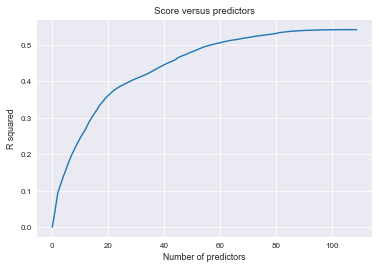

In [12]:
plt.title("Score versus predictors")
plt.xlabel('Number of predictors') 
plt.ylabel('R squared')
plt.plot(scores)
#we should see that as the number of predictors increases that the r squared score is less and less affected

In [13]:
scaler = preprocessing.StandardScaler()
scaledXarray = scaler.fit_transform(X) # Note that X is no longer a dataframe after scaling :-(
scaledX = pd.DataFrame(scaledXarray, index=X.index, columns=X.columns) # Convert it back
model.fit(scaledX, y)
predictors = scaledX.columns
coef = pd.Series(model.coef_,predictors).sort_values(ascending=False)
coef

cream                           2.638015
frozen appetizers sides         2.025280
paper goods                     1.991879
fresh vegetables                1.663534
oral hygiene                    1.556150
mint gum                        1.543343
energy sports drinks            1.521803
poultry counter                 1.432110
honeys syrups nectars           1.417479
frozen breads doughs            1.342975
pickled goods olives            1.253724
butter                          1.244508
cereal                          1.224729
doughs gelatins bake mixes      1.185773
refrigerated                    1.165348
more household                  1.033403
soap                            1.004202
vitamins supplements            0.984438
dry pasta                       0.923722
hot cereal pancake mixes        0.898417
popcorn jerky                   0.819866
frozen vegan vegetarian         0.809744
juice nectars                   0.790706
eggs                            0.769545
canned jarred ve

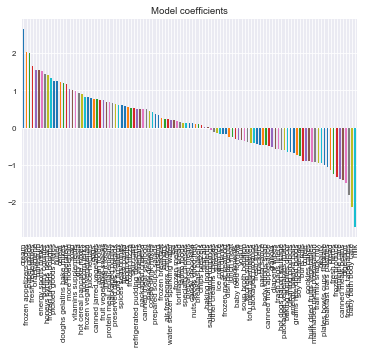

In [14]:
coef.plot(kind='bar', title="Model coefficients")

In [15]:
from sklearn.linear_model import Ridge

# assign lambda (or alpha as is used in Ridge())
ridgeReg = Ridge(alpha=50)

# Now compute the ridge regression using X, the full matrix of predictors, and y
ridgeReg.fit(scaledX, y)

Ridge(alpha=50, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [16]:
ridgeReg.score(scaledX, y)

0.5065593495080578

# Iterate each group (user) and calculate scores for each

In [17]:
df_timeline_complete.head()

,order_id,user_id,order_number,days_until_next_order,aisle,water seltzer sparkling water,frozen breakfast,milk,nuts seeds dried fruit,asian foods,...,packaged poultry,trash bags liners,plates bowls cups flatware,canned fruit applesauce,more household,frozen vegan vegetarian,diapers wipes,air fresheners candles,refrigerated pudding desserts,soap
0,3308693,1886,1,6.0,"[water seltzer sparkling water, water seltzer ...",1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1019221,1886,2,7.0,"[water seltzer sparkling water, milk, nuts see...",1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3410026,1886,3,5.0,"[milk, water seltzer sparkling water, water se...",1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2727369,1886,4,7.0,"[water seltzer sparkling water, water seltzer ...",1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,94907,1886,5,7.0,"[water seltzer sparkling water, water seltzer ...",1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [18]:
#group by user id and iterate through the groups, getting the r squared score for each
df_timeline_grouped = df_timeline_complete.groupby('user_id')
rows = []
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
for userid, group in df_timeline_grouped:
    row = {}
    
    y = group['days_until_next_order']
    X = group.drop(['aisle','days_until_next_order','order_number','order_id'], axis=1)

    lm = linear_model.LinearRegression()
    model = lm.fit(X,y)
    predictions = lm.predict(X)
    score = lm.score(X,y) 
    row["user_id"] = userid
    row["order_count"] = len(group)
    row["r_squared_score"] = score
    print("User {} made {} orders, with an r-square score of {} [{}%] This is the percentage of 'explained variance' of the predictions"
         .format(userid,len(group),score,score*100))
    rows.append(row)
    
df_scores_per_user = pd.DataFrame(rows, columns=rows[0].keys())
df_scores_per_user.sort_values("r_squared_score").head()

User 1886 made 26 orders, with an r-square score of 0.8381175420988067 [83.81175420988068%] This is the percentage of 'explained variance' of the predictions
User 5485 made 16 orders, with an r-square score of 1.0 [100.0%] This is the percentage of 'explained variance' of the predictions
User 31817 made 4 orders, with an r-square score of 0.9868475133579943 [98.68475133579942%] This is the percentage of 'explained variance' of the predictions
User 66852 made 8 orders, with an r-square score of 1.0 [100.0%] This is the percentage of 'explained variance' of the predictions
User 105334 made 7 orders, with an r-square score of 1.0 [100.0%] This is the percentage of 'explained variance' of the predictions
User 116047 made 4 orders, with an r-square score of 1.0 [100.0%] This is the percentage of 'explained variance' of the predictions
User 120239 made 3 orders, with an r-square score of 1.0 [100.0%] This is the percentage of 'explained variance' of the predictions
User 132963 made 48 orders

,user_id,order_count,r_squared_score
10,153720,9,0.688351
13,173515,44,0.751976
11,160817,42,0.812216
0,1886,26,0.838118
15,180162,14,0.913519


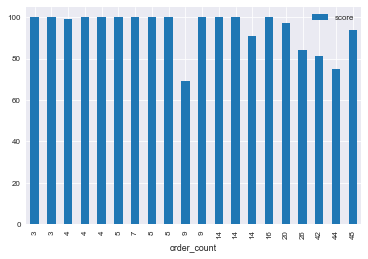

In [19]:
df_scores_per_user["score"] = round(df_scores_per_user["r_squared_score"]*100)
df = df_scores_per_user[["order_count","score"]]
df = df.sort_values("order_count").set_index("order_count");
df.plot.bar()


In [20]:

df_timeline_complete.head()

,order_id,user_id,order_number,days_until_next_order,aisle,water seltzer sparkling water,frozen breakfast,milk,nuts seeds dried fruit,asian foods,...,packaged poultry,trash bags liners,plates bowls cups flatware,canned fruit applesauce,more household,frozen vegan vegetarian,diapers wipes,air fresheners candles,refrigerated pudding desserts,soap
0,3308693,1886,1,6.0,"[water seltzer sparkling water, water seltzer ...",1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1019221,1886,2,7.0,"[water seltzer sparkling water, milk, nuts see...",1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3410026,1886,3,5.0,"[milk, water seltzer sparkling water, water se...",1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2727369,1886,4,7.0,"[water seltzer sparkling water, water seltzer ...",1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,94907,1886,5,7.0,"[water seltzer sparkling water, water seltzer ...",1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


# Iterate each user, see how accurate we can predict the orders for each one
if a user has never ordered a product from a particular aisle, do not use it in our calculations

In [39]:
from sklearn.feature_selection import VarianceThreshold

df_timeline_grouped = df_timeline_complete.groupby('user_id')
rows = []

for userid, group in df_timeline_grouped:
    row = {}
    #remove columns of all zeros - this user has never ordered from this aisle
    df = group.loc[:, (group != 0).any(axis=0)]
    print("reduced {} columns to {} columns relevant to user {}".format(group.shape[1],df.shape[1],userid))
    uY = df_timeline['days_until_next_order']
    uX = df_timeline.drop(['aisle','days_until_next_order'], axis=1)
    sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
    uX = pd.DataFrame(sel.fit_transform(uX.values))

    X_train,X_test,Y_train,Y_test=train_test_split(uX,uY,test_size=0.2)
   
    row["user_id"] = userid  
    row["feature_count"] = df.shape[1]  
    clf=svm.LinearSVC()
    clf.fit(X_train,Y_train)
    #print(clf.predict(X_test[0:1]))
    row["linear_svc_score"] = clf.score(X_test,Y_test)
    clf=svm.SVC()
    clf.fit(X_train,Y_train)
    #print(clf.predict(X_test[0:1]))
    row["svc_score"] = clf.score(X_test,Y_test)
    clf=svm.LinearSVR()
    clf.fit(X_train,Y_train)
    #print(clf.predict(X_test[0:1]))
    row["linear_svr_score"] = clf.score(X_test,Y_test)
    clf=svm.SVR()
    clf.fit(X_train,Y_train)
    #print(clf.predict(X_test[0:1]))
    row["svr_score"] = clf.score(X_test,Y_test)
    rows.append(row)
    
df = pd.DataFrame(rows,columns=["user_id","feature_count","linear_svc_score","svc_score","linear_svr_score","svr_score"])
df.head(n=20)


reduced 114 columns to 22 columns relevant to user 1886
reduced 114 columns to 49 columns relevant to user 5485
reduced 114 columns to 8 columns relevant to user 31817
reduced 114 columns to 38 columns relevant to user 66852
reduced 114 columns to 17 columns relevant to user 105334
reduced 114 columns to 41 columns relevant to user 116047
reduced 114 columns to 12 columns relevant to user 120239
reduced 114 columns to 56 columns relevant to user 132963
reduced 114 columns to 44 columns relevant to user 134477
reduced 114 columns to 23 columns relevant to user 148811
reduced 114 columns to 12 columns relevant to user 153720
reduced 114 columns to 38 columns relevant to user 160817
reduced 114 columns to 13 columns relevant to user 173462
reduced 114 columns to 36 columns relevant to user 173515
reduced 114 columns to 27 columns relevant to user 179033
reduced 114 columns to 23 columns relevant to user 180162
reduced 114 columns to 20 columns relevant to user 185476
reduced 114 columns t

,user_id,feature_count,linear_svc_score,svc_score,linear_svr_score,svr_score
0,1886,22,0.163934,0.131148,-0.079610,-0.056125
1,5485,49,0.163934,0.163934,0.032158,0.063334
2,31817,8,0.229508,0.229508,-0.107979,-0.090770
3,66852,38,0.196721,0.180328,-0.078554,-0.017840
4,105334,17,0.196721,0.278689,-0.125292,-0.119793
5,116047,41,0.114754,0.147541,-0.009256,0.027123
6,120239,12,0.180328,0.180328,-0.234059,-0.204979
7,132963,56,0.229508,0.213115,-0.031075,-0.023836
8,134477,44,0.147541,0.147541,-0.056326,-0.024716
9,148811,23,0.114754,0.114754,-0.015501,-0.019304


## unfortunately these scores are not what we had hoped for, the models outlined in this notebook underfit the data, the scores for some individual users (.27 or .26) indicate that we may be heading in the right direction but more work and a larger sample size is likely needed